In [1]:
# !source /opt/intel/oneapi/setvars.sh #comment out if not running on Intel Developer Cloud Jupyter
# !pip install transformers==4.34.1
# !pip install intel_extension_for_transformers==1.2.2
# !pip install intel_extension_for_pytorch==2.1.100
# !pip install tqdm
# !pip install einops
# !pip install neural_speed==0.2
# !pip install torch==2.1.1

In [2]:
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)


from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests



2.2.0+cu121
4.38.2


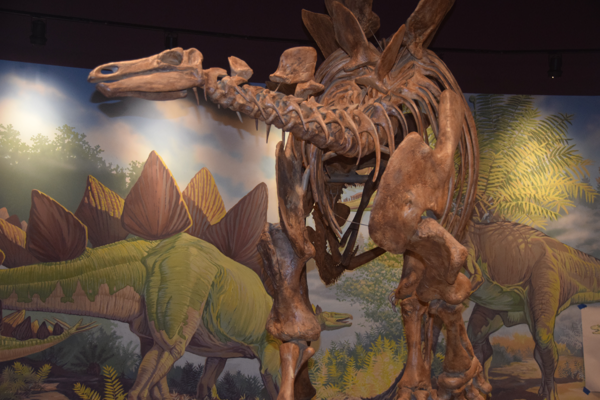

In [3]:
# url = "http://images.cocodataset.org/val2017/000000181816.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
#path = "../image/000000039769.jpg"
#path = "../image/000000181816.jpg"
#path = "image/D71_1620.png"
path = "image/DSC_0566.png"
image = Image.open(path)
MAX_SIZE = (600, 400) 
  
image.thumbnail(MAX_SIZE) 
  
image


In [4]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512")



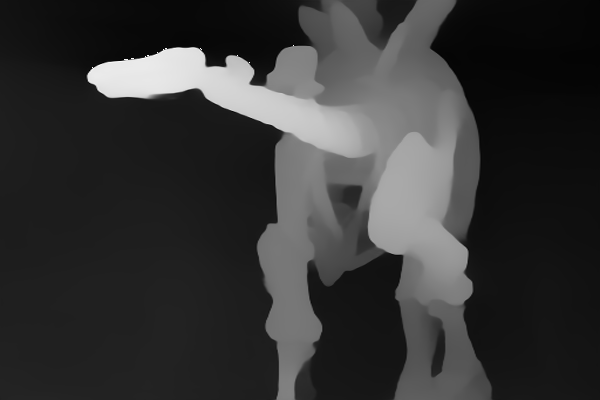

In [5]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

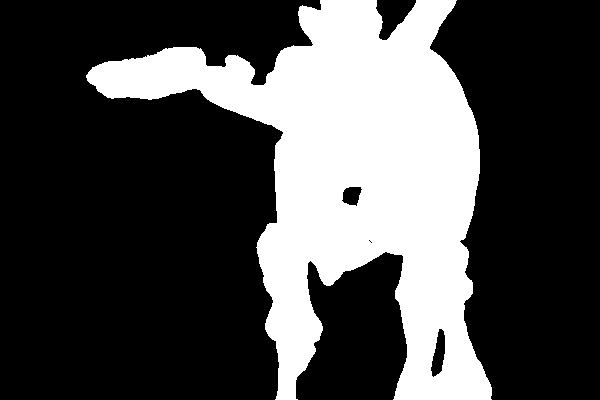

In [6]:
Threshold = 45
a = np.array(depth)
b = np.where(a>Threshold,a,0)
b[b>Threshold] = 255
mask = Image.fromarray(b).convert('L')
black = Image.fromarray(a*0).convert('L')
mask.convert('RGB').show()

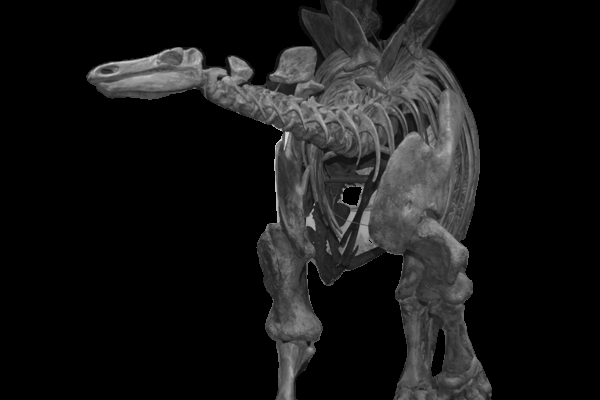

In [7]:

out = Image.composite(image, black, mask)
out.convert('RGB').show()
